<a href="https://colab.research.google.com/github/milanajudiya/Face_Emotion_Recognition_/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Introduction**
The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.
In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.


## **Problem Statements**
We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.
The solution to this problem is by recognizing facial emotions

In [1]:
!pip install tensorflow===2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras===2.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#inline matplotlib

import tensorflow 
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
import cv2

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [4]:
tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data = pd.read_csv("/content/drive/MyDrive/Face Emotion Recognition - Milan Ajudiya/Data/fer2013.csv")

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
# shape of data
data.shape

(35887, 3)

In [9]:
# check for null values
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [10]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [11]:
data["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

as see there are seven different emotion.

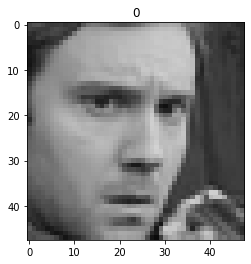

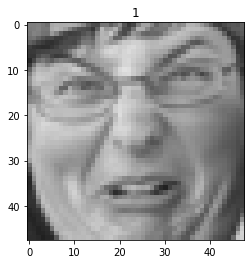

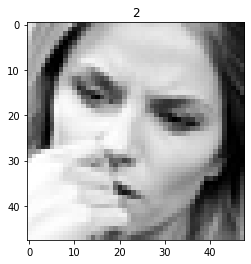

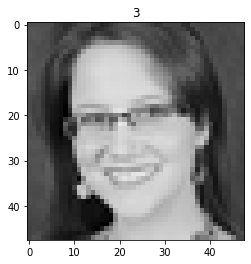

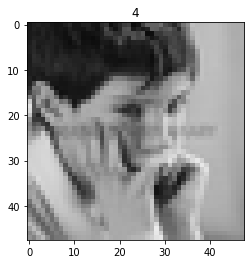

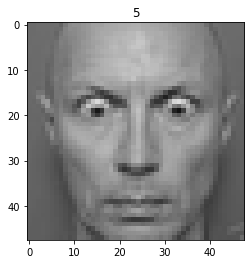

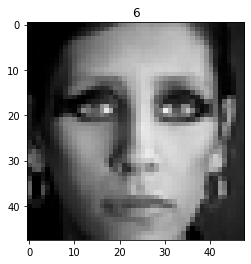

In [12]:
def show_imag(df_row, pixel_string,class_col):
  pixels = df_row[pixel_string]
  label = df_row[class_col]
  # convert into array
  picture = np.array(pixels.split())
  picture = picture.reshape(48,48)
  image = np.zeros((48,48,3))
  # slice the image
  image[:,:,0] = picture
  image[:,:,1] = picture
  image[:,:,2] = picture

  return np.array([image.astype(np.uint8),label])

# iterate overl all emotions
for emotion in range(1,8):
  pic = data[data["emotion"] == emotion -1].iloc[0]
  pic = show_imag(pic,"pixels","emotion")
  plt.imshow(pic[0])
  plt.title(pic[1])
  plt.show()

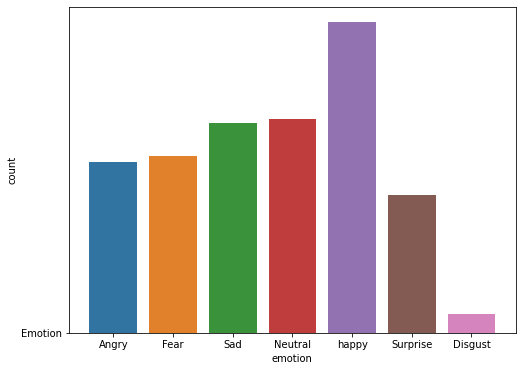

In [13]:
emotion_dict = {0 : "Angry", 1:"Disgust", 2:"Fear", 3:"happy", 4:"Sad",5:"Surprise",6:"Neutral"}
df = data.copy()
df["emotion"] = df["emotion"].map(emotion_dict)
plt.figure(figsize=(8,6))
sns.countplot(x = df["emotion"])
plt.plot("Emotion")

## **Data preprocessing**

In [14]:
# split data into train validation and test
train_data = data[data["Usage"]== "Training"]
val_data = data[data["Usage"]== "PublicTest"]
test_data = data[data["Usage"]== "PrivateTest"]


In [15]:
print("train data",train_data.shape)
print("validation data",val_data.shape)
print("test data",test_data.shape)

train data (28709, 3)
validation data (3589, 3)
test data (3589, 3)


In [16]:
for col in [train_data,val_data,test_data]:
  col.reset_index(drop=True,inplace=True)
  col.drop("Usage",axis=1,inplace=True)

In [17]:
test_data["pixels"] = test_data["pixels"].apply(lambda pixels : [int(x)for x in pixels.split()])
x_test = np.array(test_data["pixels"].tolist(),dtype ="float32").reshape(-1,48,48,1)/255.0
y_test = to_categorical(test_data["emotion"],num_classes = 7,dtype ="uint8")

In [18]:
# main directory path/
path = "/content/drive/MyDrive/Face Emotion Recognition - Milan Ajudiya/Data/"

In [20]:
def create_direc(path,class_list):
  #create train validation directory
  train_path = os.path.join(path,'train_directory__')
  val_path = os.path.join(path,'valid_directory__')
  os.mkdir(train_path)
  os.mkdir(val_path)
  for data_path,categ in {train_path :'train-' ,val_path:'valid-'}.items():
    for label in class_list:
      label_dir =os.path.join(data_path,categ+str(label))
      os.mkdir(label_dir)

In [21]:
create_direc(path,[0,1,2,3,4,5,6])

In [22]:
train_path = "/content/drive/MyDrive/Face Emotion Recognition - Milan Ajudiya/Data/train_directory__"
val_path = "/content/drive/MyDrive/Face Emotion Recognition - Milan Ajudiya/Data/valid_directory__"

In [23]:
# save image
def save_image(df1,df1_path,pixel_col,class_col,class_list,prefix):
  for i in range(len(df1)):
    pixel_string = df1[pixel_col][i]
    pixels = list(map(int,pixel_string.split()))
    matrix = np.array(pixels).reshape(48,48).astype(np.uint8)
    imag = Image.fromarray(matrix)
    for label in class_list: 
      if str(df1[class_col][i]) in prefix  + str(label):
        imag.save(df1_path + "/" + prefix + str(label)+ "/" + prefix +str(label) + "-" +str(i) + ".png")
      else:
        continue

In [24]:
# train image
save_image(train_data,train_path,"pixels","emotion",[0,1,2,3,4,5,6],'train-')


In [25]:
#validation image
save_image(val_data,val_path,"pixels","emotion",[0,1,2,3,4,5,6],'valid-')

In [26]:
# image preprocessing
from keras.preprocessing.image import ImageDataGenerator
def image_data_gen(train_path,val_path,target_size,batch_size,color_mode,class_mode):

  # initialising generator for train validation
  train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 10, horizontal_flip = True, width_shift_range = 0.1, height_shift_range= 0.1, fill_mode= "nearest")
  valid_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = train_datagen.flow_from_directory(
      train_path,
      target_size=target_size,
      batch_size=batch_size,
      color_mode=color_mode,
      seed = 42,
      shuffle = True,
      class_mode = class_mode)
  
  valid_generator = valid_datagen.flow_from_directory(
      val_path,
      target_size=target_size,
      batch_size=batch_size,
      color_mode=color_mode,
      seed = 42,
      shuffle = True,
      class_mode = class_mode)
  
  return train_generator, valid_generator

In [27]:
# image generator
train_gen, valid_gen = image_data_gen(train_path,val_path,target_size = (48,48),batch_size = 64, color_mode = "grayscale",class_mode = "categorical")

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


### **Model Building**

In [28]:
model = Sequential()
num_classes = 7

# first block
model.add(Convolution2D(64, kernel_size = 3, activation = "relu", padding = "same", input_shape =(48,48,1)))
model.add(BatchNormalization())
model.add(Convolution2D(64, kernel_size = 3, activation = "relu", padding = "same", input_shape =(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# second block
model.add(Convolution2D(128, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(Convolution2D(128, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(Convolution2D(128, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Third block
model.add(Convolution2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# fourth block
model.add(Convolution2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))



# flatten
model.add(Flatten())

model.add(Dense(num_classes, activation = "softmax"))

#summary layer
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [29]:
opt = Adam(learning_rate = 0.0001,decay = 1e-6)
model.compile(optimizer = opt , loss ="categorical_crossentropy" ,metrics =["accuracy"])

In [30]:
# training

early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0, 
                           patience = 15,
                           verbose = 1,
                           restore_best_weights = True)

#fitting 
validation_steps = (len(val_data)//64)

history = model.fit(train_gen,
                    steps_per_epoch = len(train_data)//64,
                    epochs = 100,
                    callbacks = early_stop,
                    verbose = 1,
                    validation_data = valid_gen,
                    validation_steps = validation_steps
                    )

Epoch 1/100
448/448 [==============================] - 75s 139ms/step - loss: 2.9128 - accuracy: 0.2027 - val_loss: 1.9037 - val_accuracy: 0.2143
Epoch 2/100
448/448 [==============================] - 59s 131ms/step - loss: 2.1167 - accuracy: 0.2618 - val_loss: 1.7560 - val_accuracy: 0.3214
Epoch 3/100
448/448 [==============================] - 58s 130ms/step - loss: 1.9891 - accuracy: 0.2934 - val_loss: 1.6807 - val_accuracy: 0.3661
Epoch 4/100
448/448 [==============================] - 59s 131ms/step - loss: 1.8854 - accuracy: 0.3345 - val_loss: 1.5666 - val_accuracy: 0.4009
Epoch 5/100
448/448 [==============================] - 59s 131ms/step - loss: 1.7672 - accuracy: 0.3823 - val_loss: 1.7526 - val_accuracy: 0.4090
Epoch 6/100
448/448 [==============================] - 58s 130ms/step - loss: 1.6756 - accuracy: 0.4127 - val_loss: 1.7097 - val_accuracy: 0.4347
Epoch 7/100
448/448 [==============================] - 58s 130ms/step - loss: 1.5924 - accuracy: 0.4406 - val_loss: 1.6170 -

In [32]:
#saving history of model in dataframe
df_model = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Loss plot of training and validation data')

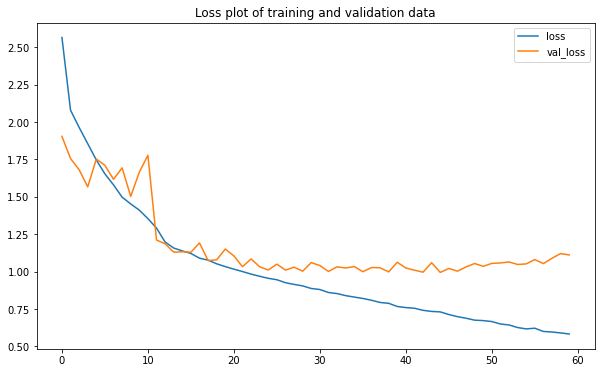

In [33]:
# plot loss
df_model[["loss","val_loss"]].plot(figsize=(10,6))
plt.title("Loss plot of training and validation data")

Text(0.5, 1.0, 'Accuracy plot of training and validation data')

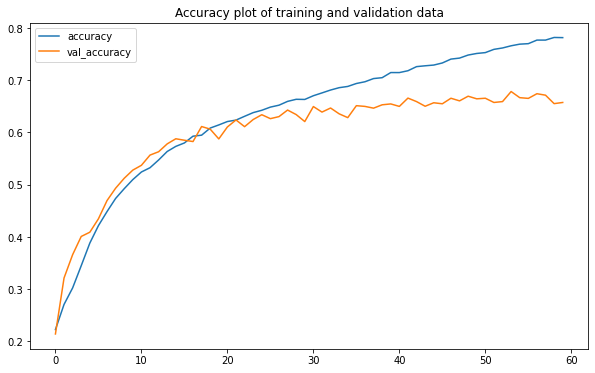

In [34]:
# plot accuracy
df_model[["accuracy","val_accuracy"]].plot(figsize=(10,6))
plt.title("Accuracy plot of training and validation data")

In [36]:
y_true = np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(x_test),axis=1)

In [37]:
print("Classification report",classification_report(y_true,y_pred))

Classification report               precision    recall  f1-score   support

           0       0.56      0.64      0.60       491
           1       0.59      0.65      0.62        55
           2       0.54      0.41      0.47       528
           3       0.88      0.86      0.87       879
           4       0.53      0.52      0.52       594
           5       0.77      0.77      0.77       416
           6       0.62      0.69      0.65       626

    accuracy                           0.67      3589
   macro avg       0.64      0.65      0.64      3589
weighted avg       0.67      0.67      0.66      3589



In [38]:
# save model
model.save("/content/drive/MyDrive/Face Emotion Recognition - Milan Ajudiya/Data/face emotion detection model/emotion_detection_model.h5")

Real Time Detection

In [39]:
model = tensorflow.keras.models.load_model("/content/drive/MyDrive/Face Emotion Recognition - Milan Ajudiya/Data/face emotion detection model/emotion_detection_model.h5")

In [44]:
face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Face Emotion Recognition - Milan Ajudiya/Data/haarcascade_frontalface_default.xml')

In [42]:
#real time detection
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret,imag = cap.read()
  height,width,channel = imag.shape
  sub_imag = imag[0:int(height/6),0:int(width)]
  heading = np.ones(sub_imag.shape, dtype = np.uint8)*0
  result = cv2.addWeighted(sub_imag, 0.82, heading, 0.18, 0)
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.9
  font_thickness = 2
  lable_color = (0, 255, 0)
  lable = "Face Emotion Detection"
  lable_dimension = cv2.getTextSize(lable,font,font_scale,font_thickness)[0]
  textX = int((result.shape[1] - lable_dimension[0])/2)
  textY = int((result.shape[0] + lable_dimension[1])/2)
  cv2.putText(result, lable,(textX,textY),font,font_scale,(0,0,0),font_thickness) 

  # prediction
  gray_image = cv2.cvtColor(imag,cv2.COLOR_BGR2GRAY)
  # detect face
  faces = face_haar_cascade.detectMultiScale(gray_image)
  try:
    for(x,y,w,h) in faces:
      #rectangle
      cv2.rectangle(imag, pt1 = (x,y), pt2 = (x+w,y+h), color = (0,0,255), thickness = 2)
      roi_gray = gray_image[y-5:y+h+5, x-5:x+w+5]
      roi_gray = cv2.resize(roi_gray,(48,48))
      image_pixels = tensorflow.keras.preprocessing.image.image_to_array(roi_gray)
      image_pixels = np.expand_dims(image_pixels,axis = 0)
      image_pixels /= 255
      prediction = model.predict(image_pixels)
      max_index = np.argmax(prediction[0])
      emotion_detection = ("Angry","Disgust","Fear","happy","Sad","Surprise","Neutral")
      emotion_prediction = emotion_detection[max_index]
      cv2.putText(imag, emotion_prediction, (int(x+w/3),int(y)),font,0.9,lable_color,2)
  except:
    pass
  imag[0:int(height/6),0:int(width)] = result
  cv2.imshow("Face Emotion Detection",imag)
  # press Q to close 
  if cv2.waitKey(1) == ord("Q"):
    break

cap.release()
cv2.destroyAllWindows()